## Drawing ROC curves with confidence bands

In [1]:
from dataclasses import dataclass
from functools import partial
from typing import Callable, Tuple

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

import score_analysis
from score_analysis import Scores

In [2]:
def generate_dataset(
    fnr: float, 
    fpr: float, 
    fnr_support: int, 
    fpr_support: int,
    pos_std: float = 1.0,
    neg_std: float = 1.0,
) -> Scores:
    """
    Generates a dataset of gaussian distributions for positive and
    negative scores, such that
    - At the given FNR value, there are fnr_support many false 
      negatives and
    - At the given FPR value, there are fpr_support many false
      positives
      
    Returns:
        A Scores object with the dataset
    """
    
    # We want P((X - mu) / si < -mu / si) = fnr
    pos_mean = -scipy.stats.norm.ppf(fnr) * pos_std
    nb_pos = int(fnr_support / fnr)
    pos = np.random.normal(loc=pos_mean, scale=pos_std, size=nb_pos)

    # We want P((X - mu) / si < -mu / si) = 1 - fpr
    neg_mean = -scipy.stats.norm.ppf(1 - fpr) * neg_std
    nb_neg = int(fpr_support / fpr)    
    neg = np.random.normal(loc=neg_mean, scale=neg_std, size=nb_neg)
    
    scores = Scores(pos=pos, neg=neg)
    return scores

In [3]:
@dataclass
class DatasetMetadata:
    fnr: float
    fpr: float
    support: int
    neg_std: float
    # FNR interval for looking at ROC curve in logspace
    fnr_lim: Tuple[float, float]
        
    def sample(self) -> Scores:
        return generate_dataset(
            fnr=self.fnr,
            fpr=self.fpr, 
            fnr_support=self.support, 
            fpr_support=self.support, 
            neg_std=self.neg_std,
        )

In [4]:
datasets = []
metas = []
for neg_std in [0.333, 1., 3.]:
    for support in [10, 100, 1000]:
        for (fnr, fpr) in [(0.01, 0.01), (0.001, 0.001), (0.01, 0.0001)]:
            meta = DatasetMetadata(
                fnr=fnr, 
                fpr=fpr, 
                support=support, 
                neg_std=neg_std,
                fnr_lim=(np.log10(fnr) - 1, np.log10(fnr) + 1),
            )
            datasets.append(meta.sample())
            metas.append(meta)

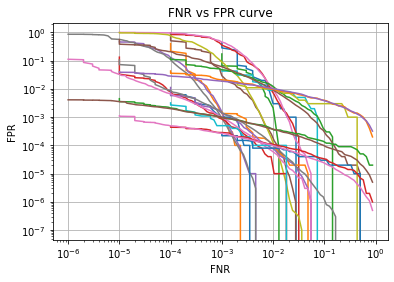

In [5]:
plt.figure()

for ds in datasets:
    fnr_init = np.logspace(-6, 0, 100, endpoint=False)
    threshold = ds.threshold_at_fnr(fnr_init)
    fnr = ds.fnr(threshold)
    fpr = ds.fpr(threshold)
    
    plt.plot(fnr, fpr)
    
plt.xscale("log")
plt.yscale("log")
plt.xlabel("FNR")
plt.ylabel("FPR")
plt.title("FNR vs FPR curve")
plt.grid()
plt.show()

## A sample dataset

We generate a dataset, where both the positive and negative scores are Gaussian distributions

$$
\begin{align}
\mathrm{pos} &\sim \mathcal N(-\mu_{\mathrm{pos}}, 1) \\
\mathrm{neg} &\sim \mathcal N(-\mu_{\mathrm{neg}}, 1) \\
\end{align}
$$

The means $\mu_{\mathrm{pos}}$ and $\mu_{\mathrm{neg}}$ are chosen such that setting the threshold at $\theta=0$ gives (on average)

$$
\begin{align}
\mathrm{FNR} &= 0.01 \\
\mathrm{FPR} &= 0.01
\end{align}
$$

We sample 10,000 positive and 10,000 negative samples. This means that at the threshold $\theta=0$ both FNR and FPR are supported by 100 samples.

In [6]:
meta = DatasetMetadata(
    fnr=0.01, 
    fpr=0.01, 
    support=100, 
    neg_std=1.0,
    fnr_lim=(-3, -1.),
)

In [7]:
scores = meta.sample()

In [8]:
print(len(scores.neg), len(scores.pos))

10000 10000


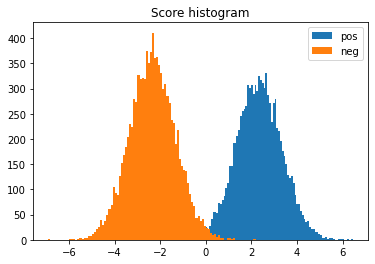

In [9]:
plt.figure()
plt.hist(scores.pos, bins=100, label="pos")
plt.hist(scores.neg, bins=100, label="neg")
plt.legend()
plt.title("Score histogram")
plt.show()

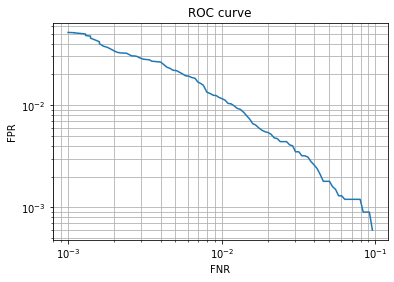

In [10]:
plt.figure()

fnr_init = np.logspace(meta.fnr_lim[0], meta.fnr_lim[1], 100, endpoint=False)
threshold = scores.threshold_at_fnr(fnr_init)
fnr = scores.fnr(threshold)
fpr = scores.fpr(threshold)
    
plt.plot(fnr, fpr)
    
plt.xscale("log")
plt.yscale("log")
plt.xlabel("FNR")
plt.ylabel("FPR")
plt.title("ROC curve")
plt.grid(which="both")
plt.show()

Now we want to add confidence bands around our ROC curve to see how much uncertainty there is.

There are multiple methods to do that.

The first method considers just the variation in FPR. We assume that FNR (x-axis) and the corresponding threshold are fixed and at each point, we assume that FPR is binomially distributed

$$
\mathrm{FPR} \sim \operatorname{Bin}(\mathrm{FP}, \mathrm{N})
$$

and we use formulas for the confidence interval of the binomial distribution.

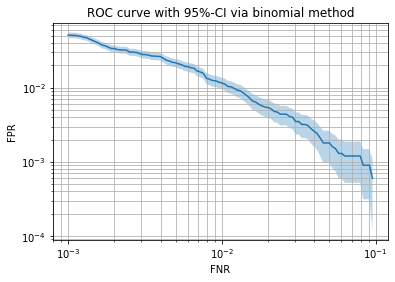

In [11]:
fnr_init = np.logspace(meta.fnr_lim[0], meta.fnr_lim[1], 100, endpoint=False)
fpr, fnr, lower, upper = score_analysis.tools.roc_with_ci(
    scores, fnr=fnr_init, method="binomial", alpha=0.05
)

plt.figure()
plt.plot(fnr, fpr)
plt.fill_between(fnr, lower, upper, alpha=.3)
plt.xscale("log")
plt.yscale("log")
plt.grid(which="both")
plt.xlabel("FNR")
plt.ylabel("FPR")
plt.title("ROC curve with 95%-CI via binomial method")
plt.show()

The second method acknowledges the fact there is variation in FNR as well as FPR.

The second method uses bootstrapping to do the following:
- Using sampling with replacement select a new sample of `scores` with the same amount of positive and negative scores.
- For each sample calculate the ROC curve, i.e., the FPR value at the given FNR values.
- Repeat the process 1,000 times to obtain 1,000 ROC curves.
- Select the 2.5%- and 97.5%-quantiles at each FNR value to be the CI band.

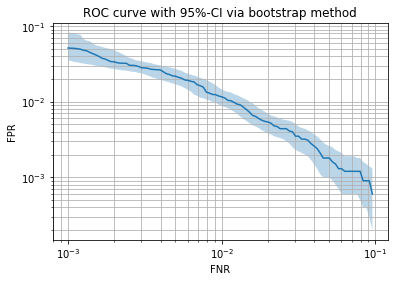

In [12]:
fnr_init = np.logspace(meta.fnr_lim[0], meta.fnr_lim[1], 100, endpoint=False)
fpr, fnr, lower, upper = score_analysis.tools.roc_with_ci(
    scores, fnr=fnr_init, method="bootstrap", alpha=0.05
)

plt.figure()
plt.plot(fnr, fpr)
plt.fill_between(fnr, lower, upper, alpha=.3)
plt.xscale("log")
plt.yscale("log")
plt.grid(which="both")
plt.xlabel("FNR")
plt.ylabel("FPR")
plt.title("ROC curve with 95%-CI via bootstrap method")
plt.show()

The pessimist method combines both bootstrap and binomial CIs to select the union of both intervals.

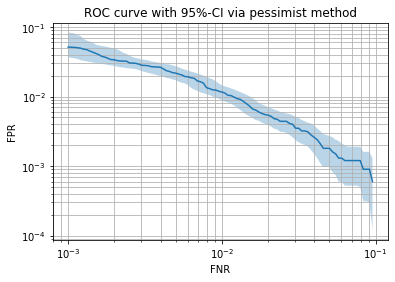

In [13]:
fnr_init = np.logspace(meta.fnr_lim[0], meta.fnr_lim[1], 100, endpoint=False)
fpr, fnr, lower, upper = score_analysis.tools.roc_with_ci(
    scores, fnr=fnr_init, method="pessimist", alpha=0.05
)

plt.figure()
plt.plot(fnr, fpr)
plt.fill_between(fnr, lower, upper, alpha=.3)
plt.xscale("log")
plt.yscale("log")
plt.grid(which="both")
plt.xlabel("FNR")
plt.ylabel("FPR")
plt.title("ROC curve with 95%-CI via pessimist method")
plt.show()

## How good is this confidence band?

In [14]:
def roc_binomial_ci(
    scores: Scores, fnr: np.ndarray, alpha: float
) -> Tuple[np.ndarray, np.ndarray]:
    _, _, lower, upper = score_analysis.tools.roc_with_ci(
        scores, fnr=fnr, method="binomial", alpha=alpha
    )
    return lower, upper

In [15]:
def roc_bootstrap_ci(
    scores: Scores, fnr: np.ndarray, alpha: float
) -> Tuple[np.ndarray, np.ndarray]:
    _, _, lower, upper = score_analysis.tools.roc_with_ci(
        scores, fnr=fnr, method="bootstrap", alpha=alpha
    )
    return lower, upper

In [16]:
def roc_pessimist_ci(
    scores: Scores, fnr: np.ndarray, alpha: float
) -> Tuple[np.ndarray, np.ndarray]:
    _, _, lower, upper = score_analysis.tools.roc_with_ci(
        scores, fnr=fnr, method="pessimist", alpha=alpha
    )
    return lower, upper

Let's test our confidence interval by sampling a new dataset with the same underlying distribution, computing its ROC curve and seeing where it lies in relation to our confidence interval.

In [17]:
fnr_init = np.logspace(
    meta.fnr_lim[0], meta.fnr_lim[1], 100, endpoint=False
)
val = meta.sample()
test = meta.sample()

lower, upper = roc_pessimist_ci(val, fnr, alpha=0.05)
threshold = val.threshold_at_fnr(fnr_init)
val_fnr = val.fnr(threshold)
val_fpr = val.fpr(threshold)

threshold = test.threshold_at_fnr(fnr_init)
test_fnr = test.fnr(threshold)
test_fpr = test.fpr(threshold)

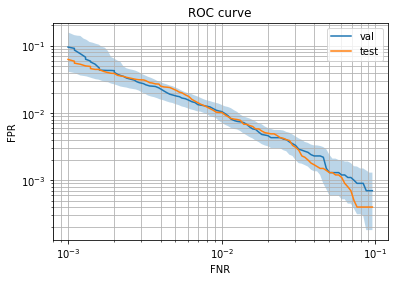

In [18]:
plt.figure()

plt.plot(val_fnr, val_fpr, label="val")
plt.fill_between(fnr_init, lower, upper, alpha=.3)
plt.plot(test_fnr, test_fpr, label="test")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("FNR")
plt.ylabel("FPR")
plt.title("ROC curve")
plt.legend()
plt.grid(which="both")
plt.show()

## Proper coverage measurement

In [19]:
def test_ci_coverage_run(
    meta: DatasetMetadata, ci_func: Callable, alpha: float
):
    fnr = np.logspace(
        meta.fnr_lim[0], meta.fnr_lim[1], 100, endpoint=False
    )
    val = meta.sample()
    test = meta.sample()
    
    lower, upper = ci_func(val, fnr, alpha)
    threshold = test.threshold_at_fnr(fnr)
    fpr = test.fpr(threshold)
    
    return np.mean((lower <= fpr) & (fpr <= upper))

In [20]:
def test_ci_coverage(
    meta: DatasetMetadata, ci_func: Callable, alpha: float, nb_runs: int
) -> float:
    results = []
    for j in range(nb_runs):
        if j % 10 == 0:
            print(j)
        res = test_ci_coverage_run(
            meta=meta, ci_func=ci_func, alpha=alpha
        )
        results.append(res)
    return results

In [21]:
res_binomial = test_ci_coverage(meta, roc_binomial_ci, alpha=0.05, nb_runs=100)

0
10
20
30
40
50
60
70
80
90


In [22]:
res_bootstrap = test_ci_coverage(meta, roc_bootstrap_ci, alpha=0.05, nb_runs=100)

0
10
20
30
40
50
60
70
80
90


In [23]:
res_pessimist = test_ci_coverage(meta, roc_pessimist_ci, alpha=0.05, nb_runs=100)

0
10
20
30
40
50
60
70
80
90


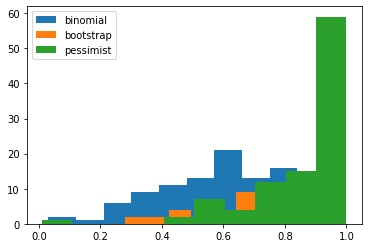

In [27]:
plt.figure()
plt.hist(res_binomial, label="binomial")
plt.hist(res_bootstrap, label="bootstrap")
plt.hist(res_pessimist, label="pessimist")
plt.legend()
plt.show()

In [29]:
print(f"Binomial avg: {np.mean(res_binomial):.2f}")
print(f"Bootstrap avg: {np.mean(res_bootstrap):.2f}")
print(f"Pessimist avg: {np.mean(res_pessimist):.2f}")

Binomial avg: 0.58
Bootstrap avg: 0.84
Pessimist avg: 0.87


In [31]:
print(f"Binomial covered: {np.sum(np.asarray(res_binomial) >= 1.0)}")
print(f"Bootstrap covered: {np.sum(np.asarray(res_bootstrap) >= 1.0)}")
print(f"Pessimist covered: {np.sum(np.asarray(res_pessimist) >= 1.0)}")

Binomial covered: 0
Bootstrap covered: 23
Pessimist covered: 26
